In [2]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.cm as cm
import matplotlib as mpl


import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

batch size: 25

using device: cuda
epoch 99 || avg loss: 0.01 || grad time elapsed: 0.1 s0.0256s/batch)
time elapsed: 2.67 min
(1000,)
batch size: 50

using device: cuda
epoch 99 || avg loss: 0.01 || grad time elapsed: 0.1 s0.0114s/batch)
time elapsed: 1.34 min
(1000,)
batch size: 100

using device: cuda
epoch 99 || avg loss: 0.02 || grad time elapsed: 0.1 s0.0267s/batch)
time elapsed: 0.70 min
(1000,)
batch size: 200

using device: cuda
epoch 99 || avg loss: 0.04 || grad time elapsed: 0.1 s0.0272s/batch)
time elapsed: 0.38 min
(1000,)
batch size: 400

using device: cuda
epoch 99 || avg loss: 0.04 || grad time elapsed: 0.1 s0.0142s/batch)
time elapsed: 0.25 min
(1000,)


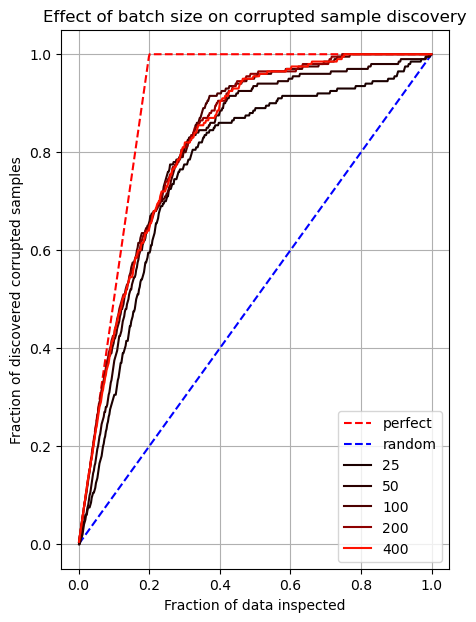

In [12]:
res = {'batch_size': [], 'p_corr':[]} 
for batch_size in [25, 50, 100, 200, 400]: 
    print('batch size:', batch_size)
    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())
    dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)
    #dvgs.pretrain_(crit=torch.nn.BCELoss(), num_workers=1, batch_size=256, lr=1e-3, epochs=25)
    print()

    tic = time.time() 
    vals_dvgs, _ = dvgs.run(crit          = torch.nn.BCELoss(), 
                        similarity     = torch.nn.CosineSimilarity(dim=1), 
                        optim          = torch.optim.Adam, 
                        lr             = 1e-3, 
                        num_epochs     = 100, 
                        compute_every  = 1,
                        batch_size     = batch_size, 
                        num_workers    = 1, 
                        grad_params    = None, 
                        verbose        = True, 
                        use_cuda       = True)
    print()
    print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

    pk, p_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs.mean(axis=1), noise_idx, train_size=1000, noise_prop=0.2)
    res['batch_size'].append(batch_size)
    res['p_corr'].append(p_corr)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'r--', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')

norm = mpl.colors.Normalize(vmin=0, vmax=2)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for ii,bs in enumerate(res['batch_size']):
    plt.plot(pk, res['p_corr'][ii], color=m.to_rgba(bs/512), label=bs, linestyle='solid')

plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.legend()
plt.grid(b=None)
plt.title('Effect of batch size on corrupted sample discovery')
plt.show()

In [13]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

res = {'batch_size': [], 'p_corr':[]} 
for batch_size in [25, 50, 100, 200, 400]: 
    print('batch size:', batch_size)
    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())
    dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)
    #dvgs.pretrain_(crit=torch.nn.BCELoss(), num_workers=1, batch_size=256, lr=1e-3, epochs=25)
    print()

    tic = time.time() 
    vals_dvgs, _ = dvgs.run(crit          = torch.nn.BCELoss(), 
                        similarity     = torch.nn.CosineSimilarity(dim=1), 
                        optim          = torch.optim.Adam, 
                        lr             = 1e-3, 
                        num_epochs     = 100, 
                        compute_every  = int(400/batch_size),
                        batch_size     = batch_size, 
                        num_workers    = 1, 
                        grad_params    = None, 
                        verbose        = True, 
                        use_cuda       = True)
    print()
    print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

    pk, p_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs.mean(axis=1), noise_idx, train_size=1000, noise_prop=0.2)
    res['batch_size'].append(batch_size)
    res['p_corr'].append(p_corr)


plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'r--', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')

norm = mpl.colors.Normalize(vmin=0, vmax=2)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for ii,bs in enumerate(res['batch_size']):
    plt.plot(pk, res['p_corr'][ii], color=m.to_rgba(bs/512), label=bs, linestyle='solid')

plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.legend()
plt.grid(b=None)
plt.title('Effect of batch size on corrupted sample discovery\n(Normalized by # iterations)')
plt.show()

batch size: 25

using device: cuda


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

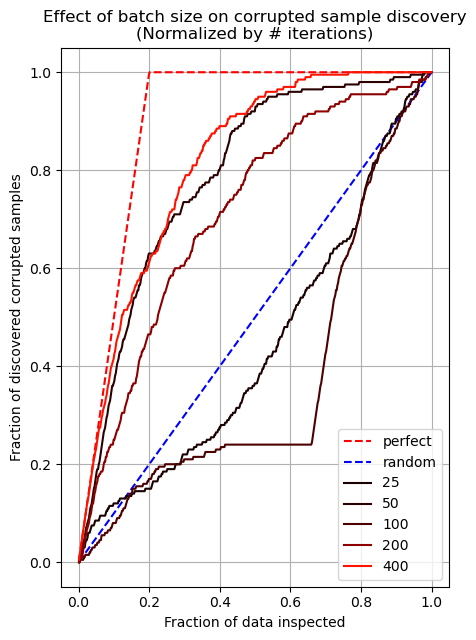

In [8]:
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'r--', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')

norm = mpl.colors.Normalize(vmin=0, vmax=2)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for ii,bs in enumerate(res['batch_size']):
    plt.plot(pk, res['p_corr'][ii], color=m.to_rgba(bs/512), label=bs, linestyle='solid')

plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.legend()
plt.grid(b=None)
plt.title('Effect of batch size on corrupted sample discovery\n(Normalized by # iterations)')
plt.show()